In [1]:
from spotXAI import spotXAI
from spotXAI import boxplot_attribution

from spotPython.data.diabetes import Diabetes
from spotPython.light.regression.netlightregression import NetLightRegression
from spotPython.utils.classes import get_removed_attributes_and_base_net

from torch.nn import ReLU
import torch

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
seed = 121315
torch.manual_seed(seed)
np.random.seed(seed)

### Exemplary dictionary with the HP config for a network

In [4]:
example_config = {
    "l1": 64,
    "epochs": 1024,
    "batch_size": 32,
    "act_fn": ReLU(),
    "optimizer": "AdamW",
    "dropout_prob": 0.04938229888019609,
    "lr_mult": 2.3689895017756495,
    "patience": 64,
    "initialization": "Default",
}

### Building the spot Lightning Architecture

In [5]:
model = NetLightRegression(**example_config, _L_in=10, _L_out=1, _torchmetric="mean_squared_error")

#### Usage of `get_removed_attributes_and_base_net` to transform the Lightning module to a plain pyTorch module

Hint: The remaining training attributes will be later used for the analyzer. This dictionary includes parameters that are relevant for the training of the model like batch size, epochs, optimizer or loss function

In [6]:
removed_attributes, torch_net = get_removed_attributes_and_base_net(net=model)
removed_attributes

{'_fabric': None,
 '_hparams_initial': "act_fn":         ReLU()
 "batch_size":     32
 "dropout_prob":   0.04938229888019609
 "epochs":         1024
 "initialization": Default
 "l1":             64
 "lr_mult":        2.3689895017756495
 "optimizer":      AdamW
 "patience":       64,
 '_device': device(type='cpu'),
 '_param_requires_grad_state': {},
 '_hparams_name': 'kwargs',
 '_torchmetric': 'mean_squared_error',
 '_strict_loading': None,
 'prepare_data_per_node': True,
 '_log_hyperparams': True,
 '_automatic_optimization': True,
 '_example_input_array': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0

In [7]:
torch_net

NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04938229888019609, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04938229888019609, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04938229888019609, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.04938229888019609, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)

### Select a data set

In [8]:
dataset = Diabetes(target_type=torch.float)

### Define the analyzer by handing over the generated model, the data set, a train split ratio and the dictionary consisting of the "removed attributes"


In [9]:
analyzer = spotXAI(model=torch_net, data=dataset, train_split=0.6, training_attributes=removed_attributes, seed=seed)

#### Train the weights of the model

In [10]:
analyzer.train_model()

epochs 1/1024
train loss:  905.9894409179688
epochs 2/1024
train loss:  885.5709838867188
epochs 3/1024
train loss:  890.6395263671875
epochs 4/1024
train loss:  890.0051879882812
epochs 5/1024
train loss:  875.1885375976562
epochs 6/1024
train loss:  836.3643188476562
epochs 7/1024
train loss:  817.5126953125
epochs 8/1024
train loss:  732.0361938476562
epochs 9/1024
train loss:  579.4774780273438
epochs 10/1024
train loss:  356.49139404296875
epochs 11/1024
train loss:  177.50445556640625
epochs 12/1024
train loss:  163.5115203857422
epochs 13/1024
train loss:  156.91114807128906
epochs 14/1024
train loss:  140.58384704589844
epochs 15/1024
train loss:  141.00782775878906
epochs 16/1024
train loss:  131.1641387939453
epochs 17/1024
train loss:  126.49010467529297
epochs 18/1024
train loss:  129.897705078125
epochs 19/1024
train loss:  124.4501724243164
epochs 20/1024
train loss:  120.87416076660156
epochs 21/1024
train loss:  118.26759338378906
epochs 22/1024
train loss:  116.5919189

#### Perform the attribution analysis

In [11]:
# baseline = torch.Tensor([[0.1,0.1,0.1,0.2,0.1,0.1,0.1,0.2,0.1, 0.2]])
df = analyzer.get_n_most_sig_features(n_rel=10, attr_method="KernelShap", baseline=None, abs_attr=True)

In [12]:
df

,Feature Index,KernelShapAttribution
0,1,897.079834
1,9,773.619812
2,6,672.121460
3,0,666.067871
4,3,595.165283
5,5,399.469788
6,4,-347.050903
7,2,344.043213
8,7,207.993362
9,8,198.407898


#### Plot the results

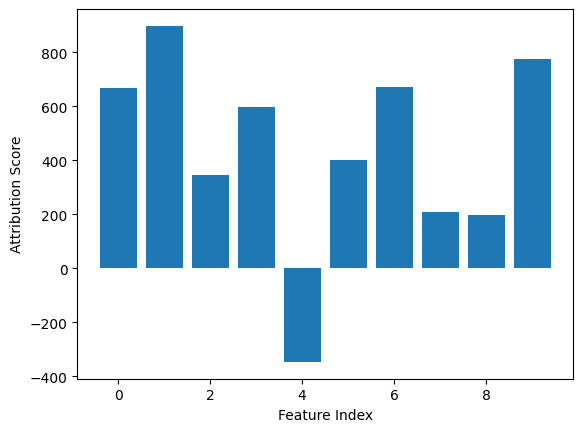

In [13]:
plt.bar(df["Feature Index"], df["KernelShapAttribution"])
plt.xlabel("Feature Index")
plt.ylabel("Attribution Score")
plt.show()

### Perform layer conductance analysis

In [14]:
lc_val = analyzer.get_layer_conductance(layer_idx=12)

Conductance analysis for layer:  Linear(in_features=16, out_features=1, bias=True)


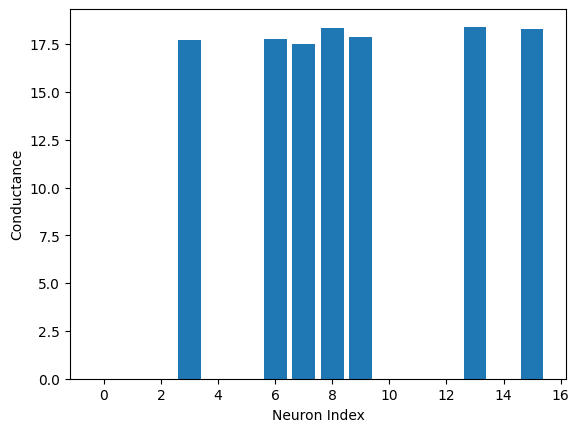

In [15]:
plt.bar(range(len(lc_val)), lc_val)
plt.xlabel("Neuron Index")
plt.ylabel("Conductance")
plt.show()

### Check the distribution of all attribution values

In [16]:
attribution_distribution = analyzer.get_attribution_distribution(attr_method="KernelShap")

In [17]:
attribution_distribution

[tensor([  2.0470,  -5.9097,  12.7262,   9.0386, -11.5135,   6.8335,  -2.2465,
           0.5395,  -2.4317,   8.5945]),
 tensor([ -1.9444,  14.2179,  23.9844,  13.8118, -15.1619,  11.6540,   1.5709,
          -2.6894,  26.3023,   7.1622]),
 tensor([  2.8749,   0.5500, -21.4532,   4.4803,   0.7299,   6.0819,  -9.1209,
          -1.6115, -34.2687,  -0.0527]),
 tensor([ -1.2430,  19.6701, -22.0765,   0.1343,  29.8441, -18.6713,  35.8577,
          -1.3843,  17.1229,   0.1316]),
 tensor([  3.0601, -19.7669, -18.5128,   3.4562,  -5.0914,  15.3247,  -0.4653,
           5.1079, -48.7899,  12.0192]),
 tensor([  4.3662, -12.3304,   8.0166,  -6.7379,   6.5919,  -0.7195,  23.3312,
         -10.3177,  24.8405,   6.5790]),
 tensor([-1.4682, 20.5906, 32.2080, 27.1041, 13.7393, -8.6947,  5.3860, -2.8423,
         17.1818, -2.2440]),
 tensor([10.3336, 22.4827, 21.3155, -4.2512,  4.5529, -1.0407,  1.6071,  0.0421,
         -7.9910,  8.2364]),
 tensor([  7.1232,  20.3025, -13.3195,  -6.3052,  16.5713, -

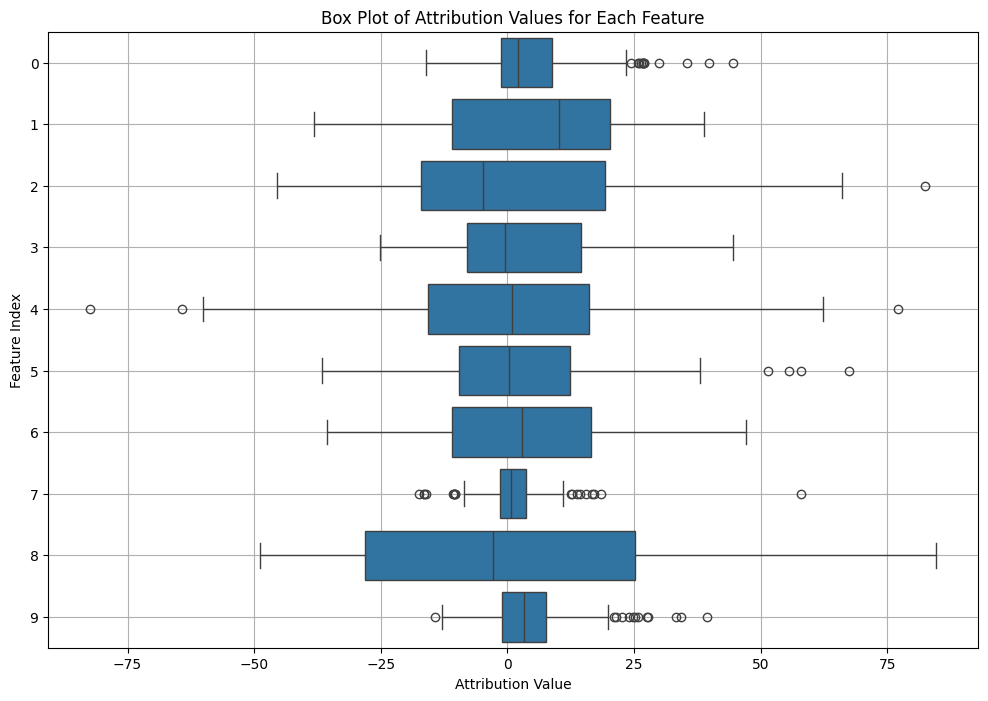

In [18]:
boxplot_attribution(attribution_distribution)